In [1]:
import numpy
import tqdm
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from dirichlet_python.dirichletcal.calib.fulldirichlet import FullDirichletCalibrator
%matplotlib inline
font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

In [2]:
# specify the dataset settings (a mixutre of gaussian)

pi = numpy.array([0.5, 0.5])
ita_0 = numpy.array([0.5, 0.5])
ita_1 = numpy.array([0.5, 0.5])
mu_0_0 = numpy.array([4.0]) 
mu_0_1 = numpy.array([-64.0]) 
mu_1_0 = numpy.array([-4.0])
mu_1_1 = numpy.array([72.0 ]) 
cov_0_0 = numpy.array([960.0])
cov_0_1 = numpy.array([1280.0])
cov_1_0 = numpy.array([980.0])
cov_1_1 = numpy.array([1024.0])

In [3]:
# generate the feature and label samples

N = 10000
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3]]).transpose()

In [4]:
# train a NN classifier 
mdl = MLPClassifier(verbose=True)
mdl.fit(x, numpy.argmax(y,axis=1))

Iteration 1, loss = 0.91281577
Iteration 2, loss = 0.52007910
Iteration 3, loss = 0.51744178
Iteration 4, loss = 0.51540800
Iteration 5, loss = 0.51503740
Iteration 6, loss = 0.51328842
Iteration 7, loss = 0.51359261
Iteration 8, loss = 0.51056639
Iteration 9, loss = 0.51065076
Iteration 10, loss = 0.50929873
Iteration 11, loss = 0.50947058
Iteration 12, loss = 0.51064240
Iteration 13, loss = 0.50928466
Iteration 14, loss = 0.50998649
Iteration 15, loss = 0.50879665
Iteration 16, loss = 0.50896140
Iteration 17, loss = 0.51198469
Iteration 18, loss = 0.51915762
Iteration 19, loss = 0.50963882
Iteration 20, loss = 0.51059903
Iteration 21, loss = 0.51169914
Iteration 22, loss = 0.51160136
Iteration 23, loss = 0.51163381
Iteration 24, loss = 0.51046640
Iteration 25, loss = 0.50892794
Iteration 26, loss = 0.51069253
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

In [5]:
# get predicted scores on samples
s = mdl.predict_proba(x)

In [6]:
# get predicted scores on an interval
N_grid = 64
edge = 160.0
v_edge = 160.0
x_mesh = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)
s_mesh = mdl.predict_proba(x_mesh)

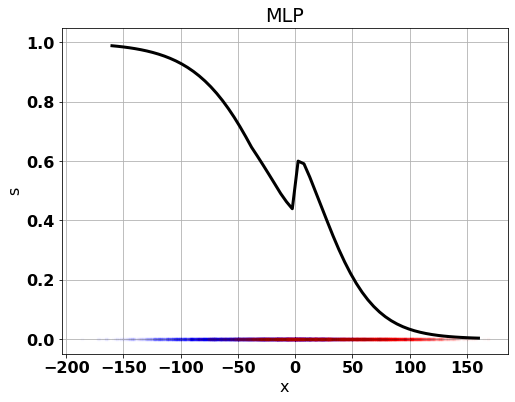

In [7]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.plot(x_mesh, s_mesh[:, 0], 'k', linewidth=3.0)
matplotlib.pyplot.plot(x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP')
matplotlib.pyplot.ylim([-0.05, 1.05])
matplotlib.pyplot.grid()

In [8]:
N = int(4096)
N_sim = int(1e4)

p_s = numpy.zeros(N_grid-1)
p_s_0 = numpy.zeros(N_grid-1)
p_s_1 = numpy.zeros(N_grid-1)

# p_s_hat = numpy.zeros(N_grid - 1)
# p_s_0_hat = numpy.zeros(N_grid - 1)
# p_s_1_hat = numpy.zeros(N_grid - 1)

for i in tqdm.trange(0, N_sim):
    tmp_y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    tmp_x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    tmp_x = tmp_x[0] * tmp_y[:, 0].reshape(-1, 1) + tmp_x[1] * tmp_y[:, 1].reshape(-1, 1) + \
            tmp_x[2] * tmp_y[:, 2].reshape(-1, 1) + tmp_x[3] * tmp_y[:, 3].reshape(-1, 1)

    tmp_y = numpy.vstack([tmp_y[:, 0] + tmp_y[:, 1],
                          tmp_y[:, 2] + tmp_y[:, 3]]).transpose()

    tmp_s = mdl.predict_proba(tmp_x)
    
    # s_hat = cal.predict_proba(s)

    p_s = p_s + numpy.histogram(tmp_s[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0 = p_s_0 + numpy.histogram(tmp_s[tmp_y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1 = p_s_1 + numpy.histogram(tmp_s[tmp_y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]

    # p_s_hat = p_s_hat + numpy.histogram(s_hat[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_0_hat = p_s_0_hat + numpy.histogram(s_hat[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_1_hat = p_s_1_hat + numpy.histogram(s_hat[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
                                                    
p_s = p_s + 1
p_s_0 = p_s_0 + 1
p_s_1 = p_s_1 + 1

# p_s_hat = p_s_hat
# p_s_0_hat = p_s_0_hat
# p_s_1_hat = p_s_1_hat

100%|██████████| 10000/10000 [00:53<00:00, 187.54it/s]


In [9]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0.ravel(),
                          pi[1] * p_s_1.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat = p_x_y_hat / p_x_hat

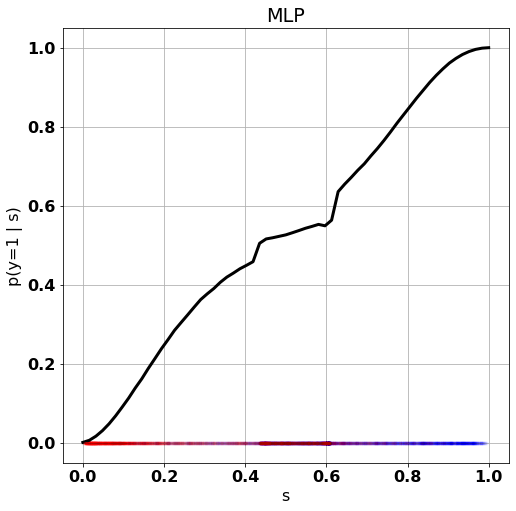

In [10]:
# draw reliability diagram

matplotlib.pyplot.figure(figsize=(8.0, 8.0))
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'k', linewidth=3)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('p(y=1 | s)')
matplotlib.pyplot.title('MLP')
matplotlib.pyplot.grid()

In [11]:
cal = FullDirichletCalibrator()
cal.fit(s, numpy.argmax(y,axis=1))

/home/sh/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/sh/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sh/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FullDirichletCalibrator()

In [12]:
s_mesh_hat = cal.predict_proba(s_mesh)

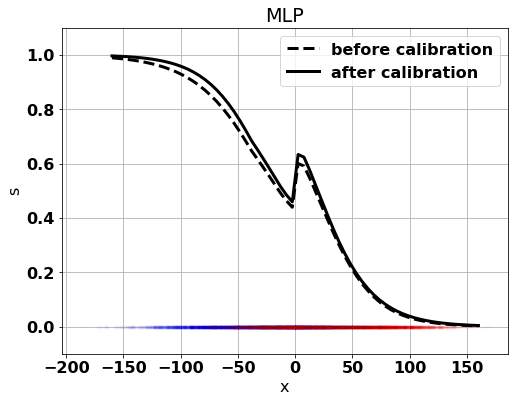

In [13]:
matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.plot(x_mesh, s_mesh[:, 0], 'k--', linewidth=3.0)
matplotlib.pyplot.plot(x_mesh, s_mesh_hat[:, 0], 'k', linewidth=3.0)
matplotlib.pyplot.plot(x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration'])

In [14]:
N = int(4096)
N_sim = int(1e4)

p_s_hat = numpy.zeros(N_grid-1)
p_s_0_hat = numpy.zeros(N_grid-1)
p_s_1_hat = numpy.zeros(N_grid-1)

# p_s_hat = numpy.zeros(N_grid - 1)
# p_s_0_hat = numpy.zeros(N_grid - 1)
# p_s_1_hat = numpy.zeros(N_grid - 1)

for i in tqdm.trange(0, N_sim):
    tmp_y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    tmp_x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    tmp_x = tmp_x[0] * tmp_y[:, 0].reshape(-1, 1) + tmp_x[1] * tmp_y[:, 1].reshape(-1, 1) + \
            tmp_x[2] * tmp_y[:, 2].reshape(-1, 1) + tmp_x[3] * tmp_y[:, 3].reshape(-1, 1)

    tmp_y = numpy.vstack([tmp_y[:, 0] + tmp_y[:, 1],
                          tmp_y[:, 2] + tmp_y[:, 3]]).transpose()

    tmp_s = mdl.predict_proba(tmp_x)
    
    tmp_s = cal.predict_proba(tmp_s)

    p_s_hat = p_s_hat + numpy.histogram(tmp_s[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0_hat = p_s_0_hat + numpy.histogram(tmp_s[tmp_y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1_hat = p_s_1_hat + numpy.histogram(tmp_s[tmp_y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]

    # p_s_hat = p_s_hat + numpy.histogram(s_hat[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_0_hat = p_s_0_hat + numpy.histogram(s_hat[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_1_hat = p_s_1_hat + numpy.histogram(s_hat[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
                                                    
p_s_hat = p_s_hat + 1
p_s_0_hat = p_s_0_hat + 1
p_s_1_hat = p_s_1_hat + 1

# p_s_hat = p_s_hat
# p_s_0_hat = p_s_0_hat
# p_s_1_hat = p_s_1_hat

100%|██████████| 10000/10000 [01:32<00:00, 108.42it/s]


In [15]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0_hat.ravel(),
                          pi[1] * p_s_1_hat.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat_hat = p_x_y_hat / p_x_hat

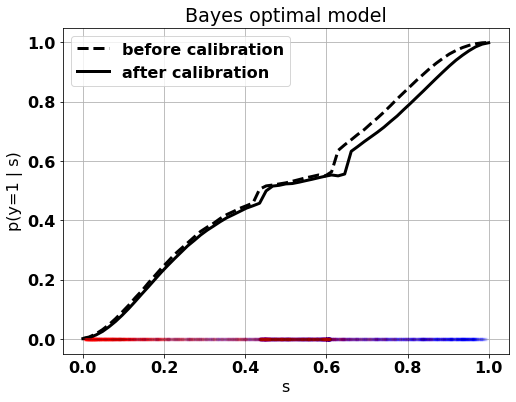

In [16]:
# draw reliability diagram

matplotlib.pyplot.figure(figsize=(8.0, 6.0))
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'k--', linewidth=3)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat_hat[0, :], 'k', linewidth=3)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('p(y=1 | s)')
matplotlib.pyplot.title('Bayes optimal model')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration'])